In [110]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from google.colab import drive
import pandas as pd
import numpy as np
import itertools
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [109]:
drive.mount('/content/drive')

# Update the path EXACTLY as it appears in your Drive
data_path = "/content/drive/MyDrive/dataset/Final Dataset.pkl"

df = pd.read_pickle(data_path)

print("Dataset loaded successfully!")
print("Shape:", df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully!
Shape: (2847862, 19)


,primaryid,age_years,age_group,sex_clean,occr_country,is_elderly,is_pediatric,suspect_drugs,num_suspect_drugs,polypharmacy_category,all_reactions,num_reactions,has_serious_reaction,reaction_severity,outcome_codes,is_serious_outcome,outcome_descriptions,indications,age_years_missing
0,1001678125,56.0,middle_age,Female,CA,0,0,"[SANDOSTATIN LAR DEPOT, SANDOSTATIN]",2.0,dual_therapy,"[BLOOD CREATINE INCREASED, FALL, SINUSITIS, SK...",76.0,1,extreme,[OT],0,[Other Serious (Important Medical Event)],[NEUROENDOCRINE TUMOUR],0
1,1002872124,57.0,middle_age,Female,CA,0,0,"[SANDOSTATIN LAR DEPOT, AFINITOR, SANDOSTATIN]",3.0,moderate_poly,"[PNEUMONITIS, ABDOMINAL PAIN UPPER, CARCINOID ...",24.0,1,extreme,"[OT, HO]",1,"[Other Serious (Important Medical Event), Hosp...","[PANCREATIC NEUROENDOCRINE TUMOUR, CARCINOID T...",0
2,100293663,32.0,adult,Male,AU,0,0,"[CYCLOSPORINE, BASILIXIMAB, MYCOPHENOLATE MOFE...",4.0,moderate_poly,"[STAPHYLOCOCCAL INFECTION, MYCOBACTERIUM HAEMO...",4.0,0,moderate,[OT],0,[Other Serious (Important Medical Event)],"[RENAL TRANSPLANT, IMMUNOSUPPRESSANT DRUG THER...",0
3,1005450710,68.0,elderly,Female,US,1,0,"[ENBREL, METHOTREXATE SODIUM]",2.0,dual_therapy,"[DRUG HYPERSENSITIVITY, DRUG ERUPTION]",2.0,0,few,[],0,[],[],0
4,1005762118,57.0,middle_age,Male,CA,0,0,"[EXELON, XOLAIR]",2.0,dual_therapy,"[PHOTOSENSITIVITY REACTION, PARKINSON'S DISEAS...",32.0,0,extreme,[HO],1,[Hospitalization - Initial or Prolonged],"[ANTIBIOTIC PROPHYLAXIS, ASTHMA]",0


In [111]:
df.columns


Index(['primaryid', 'age_years', 'age_group', 'sex_clean', 'occr_country',
       'is_elderly', 'is_pediatric', 'suspect_drugs', 'num_suspect_drugs',
       'polypharmacy_category', 'all_reactions', 'num_reactions',
       'has_serious_reaction', 'reaction_severity', 'outcome_codes',
       'is_serious_outcome', 'outcome_descriptions', 'indications',
       'age_years_missing'],
      dtype='object')

## SELECT TOP-20 DRUGS & TOP-20 REACTIONS



In [112]:
# Flatten full lists
all_drugs = list(itertools.chain.from_iterable(df["suspect_drugs"]))
all_reacts = list(itertools.chain.from_iterable(df["all_reactions"]))

top20_drugs = pd.Series(all_drugs).value_counts().head(20).index.tolist()
top20_reacts = pd.Series(all_reacts).value_counts().head(20).index.tolist()

top_drugs_set = set(top20_drugs)
top_reacts_set = set(top20_reacts)

print("\nTop 20 Drugs:", top20_drugs)
print("Top 20 Reactions:", top20_reacts)




Top 20 Drugs: ['DUPIXENT', 'MOUNJARO', 'PREDNISONE', 'RITUXIMAB', 'HUMIRA', 'VEDOLIZUMAB', 'REPATHA', 'METHOTREXATE', 'REVLIMID', 'SKYRIZI', 'ZEPBOUND', 'CYCLOPHOSPHAMIDE', 'ACETAMINOPHEN', 'RINVOQ', 'OZEMPIC', 'LENALIDOMIDE', 'COSENTYX', 'CARBOPLATIN', 'DEXAMETHASONE', 'GENOTROPIN']
Top 20 Reactions: ['OFF LABEL USE', 'DRUG INEFFECTIVE', 'FATIGUE', 'NAUSEA', 'PRODUCT DOSE OMISSION ISSUE', 'DIARRHOEA', 'DEATH', 'HEADACHE', 'PAIN', 'DYSPNOEA', 'ARTHRALGIA', 'PRURITUS', 'RASH', 'VOMITING', 'DIZZINESS', 'CONDITION AGGRAVATED', 'INAPPROPRIATE SCHEDULE OF PRODUCT ADMINISTRATION', 'MALAISE', 'PRODUCT USE IN UNAPPROVED INDICATION', 'PNEUMONIA']


## FILTER ROWS TO KEEP ONLY CASES WITH TOP DRUG/REACTION

In [113]:
def filter_list(lst, allowed):
    if not isinstance(lst, list): return []
    return [x for x in lst if x in allowed]

df["filtered_drugs"] = df["suspect_drugs"].apply(lambda x: filter_list(x, top_drugs_set))
df["filtered_reactions"] = df["all_reactions"].apply(lambda x: filter_list(x, top_reacts_set))

mask = (df["filtered_drugs"].str.len() > 0) | (df["filtered_reactions"].str.len() > 0)
df_reduced = df[mask].copy()

print("\nRows after keeping only top-20 items:", df_reduced.shape)


Rows after keeping only top-20 items: (1618829, 21)


## TRIM EACH CASE (MAX 3 DRUGS + MAX 5 REACTIONS)


In [114]:
df_reduced["drugs_trimmed"] = df_reduced["filtered_drugs"].apply(lambda x: x[:3])
df_reduced["reacts_trimmed"] = df_reduced["filtered_reactions"].apply(lambda x: x[:5])

mask_trim = (df_reduced["drugs_trimmed"].str.len() > 0) | \
            (df_reduced["reacts_trimmed"].str.len() > 0)

df_reduced = df_reduced[mask_trim].copy()

print("\nRows after trimming:", df_reduced.shape)


Rows after trimming: (1618829, 23)


## VALIDATION OF DIMENSION REDUCTION

In [115]:
# 1️⃣ ORIGINAL DISTRIBUTIONS
orig_drug_counts = pd.Series(all_drugs).value_counts()
orig_react_counts = pd.Series(all_reacts).value_counts()

# 2️⃣ REDUCED DISTRIBUTIONS (after filtering + trimming)
reduced_drugs = list(itertools.chain.from_iterable(df_reduced["drugs_trimmed"]))
reduced_reacts = list(itertools.chain.from_iterable(df_reduced["reacts_trimmed"]))

reduced_drug_counts = pd.Series(reduced_drugs).value_counts()
reduced_react_counts = pd.Series(reduced_reacts).value_counts()

In [116]:
# 3️⃣ ALIGN TOP 20 ONLY
orig_top20_drugs = orig_drug_counts.loc[top20_drugs]
reduced_top20_drugs = reduced_drug_counts.loc[top20_drugs].fillna(0)

orig_top20_reacts = orig_react_counts.loc[top20_reacts]
reduced_top20_reacts = reduced_react_counts.loc[top20_reacts].fillna(0)

In [117]:
# 4️⃣ CORRELATION TEST (should be > 0.85 ideally)
corr_drugs = orig_top20_drugs.corr(reduced_top20_drugs)
corr_reacts = orig_top20_reacts.corr(reduced_top20_reacts)

print("=== DIMENSION REDUCTION VALIDATION ===")
print(f"Correlation (Original vs Reduced Drug Frequencies): {corr_drugs:.4f}")
print(f"Correlation (Original vs Reduced Reaction Frequencies): {corr_reacts:.4f}")


=== DIMENSION REDUCTION VALIDATION ===
Correlation (Original vs Reduced Drug Frequencies): 0.9994
Correlation (Original vs Reduced Reaction Frequencies): 0.9969


## SAMPLE 100,000 ROWS FOR FP-GROWTH

In [118]:
SAMPLE_SIZE = 100_000

if df_reduced.shape[0] > SAMPLE_SIZE:
    df_sample = df_reduced.sample(SAMPLE_SIZE, random_state=42)
else:
    df_sample = df_reduced.copy()

print("\nSample size:", df_sample.shape)


Sample size: (100000, 23)


### SECTION 8 — ADD AGE, SEX, AND SERIOUS OUTCOME LABELS

(Purpose: Required for 3rd rule type (Drug + Sex → Serious outcome))

In [119]:
df_sample["age_bucket"] = pd.cut(
    df_sample["age_years"],
    bins=[0, 18, 40, 65, 200],
    labels=["AGE_0_18", "AGE_19_40", "AGE_41_65", "AGE_65PLUS"],
    include_lowest=True
)

df_sample["age_bucket"] = df_sample["age_bucket"].astype(str)

df_sample["sex_bucket"] = df_sample["sex_clean"].map({
    "M": "SEX_M",
    "F": "SEX_F"
}).fillna("SEX_OTHER")

df_sample["serious_flag"] = df_sample["is_serious_outcome"].apply(
    lambda x: "SERIOUS_YES" if x == 1 else "SERIOUS_NO"
)

##BUILD ITEMSET FOR EACH REPORT

(Purpose: Convert each case into a transaction of items & Includes drugs, reactions, age, sex, outcome)

In [120]:
def build_items(row):
    items = []

    # Drugs
    items += [f"DRUG_{d.replace(' ','_')}" for d in row["drugs_trimmed"]]

    # Reactions
    items += [f"REACT_{r.replace(' ','_')}" for r in row["reacts_trimmed"]]

    # Demographics
    items.append(row["age_bucket"])
    items.append(row["sex_bucket"])
    items.append(row["serious_flag"])

    return list(set(items))

df_sample["items"] = df_sample.apply(build_items, axis=1)

print("\nExample transaction:", df_sample["items"].iloc[0])


Example transaction: ['DRUG_LENALIDOMIDE', 'REACT_INAPPROPRIATE_SCHEDULE_OF_PRODUCT_ADMINISTRATION', np.str_('nan'), 'SERIOUS_NO', 'SEX_OTHER', 'REACT_OFF_LABEL_USE']


##TRANSACTION ENCODING

In [121]:
transactions = df_sample["items"].tolist()

te = TransactionEncoder()
df_binary = pd.DataFrame(te.fit(transactions).transform(transactions),
                         columns=te.columns_)

print("\nBinary matrix:", df_binary.shape)


Binary matrix: (100000, 48)


##RUN FP-GROWTH

In [122]:
MIN_SUPPORT = 0.002
MAX_LEN = 3

frequent_itemsets = fpgrowth(
    df_binary,
    min_support=MIN_SUPPORT,
    use_colnames=True,
    max_len=MAX_LEN
)

print("\nFrequent itemsets found:", len(frequent_itemsets))

rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.2
)

print("Total rules:", len(rules))



Frequent itemsets found: 1419
Total rules: 1900


/usr/local/lib/python3.12/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


## EXTRACT RULES FOR 3 PROJECT OBJECTIVES

In [123]:
# 1️⃣ Drug → Reaction
drug_to_reaction = rules[
    rules["antecedents"].apply(lambda x: any("DRUG_" in a for a in x)) &
    rules["consequents"].apply(lambda x: any("REACT_" in c for c in x))
]

print("\nDrug → Reaction rules:", len(drug_to_reaction))
display(drug_to_reaction.head(10))


# 2️⃣ Drug + Age → Reaction
drug_age_to_reaction = rules[
    rules["antecedents"].apply(lambda x:
        any("DRUG_" in a for a in x) and any("AGE_" in a for a in x)
    ) &
    rules["consequents"].apply(lambda x: any("REACT_" in c for c in x))
]

print("\nDrug + Age → Reaction:", len(drug_age_to_reaction))
display(drug_age_to_reaction.head(10))


# 3️⃣ Drug + Sex → Serious Outcome
drug_sex_to_serious = rules[
    rules["antecedents"].apply(lambda x:
        any("DRUG_" in a for a in x) and any("SEX_" in a for a in x)
    ) &
    rules["consequents"].apply(lambda x: "SERIOUS_YES" in list(x))
]

print("\nDrug + Sex → Serious Outcome:", len(drug_sex_to_serious))
display(drug_sex_to_serious.head(10))


Drug → Reaction rules: 20


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
309,"(REACT_PRODUCT_USE_IN_UNAPPROVED_INDICATION, D...",(REACT_PRURITUS),0.01183,0.04622,0.00258,0.218090,4.718512,1.0,0.002033,1.219807,0.797503,0.046512,0.180198,0.136955
567,"(DRUG_REVLIMID, SERIOUS_NO)",(REACT_OFF_LABEL_USE),0.01695,0.13992,0.00341,0.201180,1.437821,1.0,0.001038,1.076688,0.309754,0.022221,0.071226,0.112776
568,"(AGE_65PLUS, DRUG_REVLIMID)",(REACT_OFF_LABEL_USE),0.01377,0.13992,0.00287,0.208424,1.489595,1.0,0.000943,1.086541,0.333266,0.019029,0.079649,0.114468
794,(DRUG_RITUXIMAB),(REACT_OFF_LABEL_USE),0.02432,0.13992,0.00680,0.279605,1.998322,1.0,0.003397,1.193901,0.512033,0.043191,0.162410,0.164102
842,"(SEX_OTHER, DRUG_RITUXIMAB)",(REACT_OFF_LABEL_USE),0.02432,0.13992,0.00680,0.279605,1.998322,1.0,0.003397,1.193901,0.512033,0.043191,0.162410,0.164102
843,(DRUG_RITUXIMAB),"(REACT_OFF_LABEL_USE, SEX_OTHER)",0.02432,0.13992,0.00680,0.279605,1.998322,1.0,0.003397,1.193901,0.512033,0.043191,0.162410,0.164102
845,"(DRUG_RITUXIMAB, SERIOUS_NO)",(REACT_OFF_LABEL_USE),0.01113,0.13992,0.00354,0.318059,2.273151,1.0,0.001983,1.261224,0.566386,0.023998,0.207119,0.171680
847,"(SERIOUS_YES, DRUG_RITUXIMAB)",(REACT_OFF_LABEL_USE),0.01319,0.13992,0.00326,0.247157,1.766416,1.0,0.001414,1.142443,0.439681,0.021755,0.124683,0.135228
848,"(AGE_41_65, DRUG_RITUXIMAB)",(REACT_OFF_LABEL_USE),0.00822,0.13992,0.00216,0.262774,1.878028,1.0,0.001010,1.166643,0.471402,0.014797,0.142840,0.139106
850,"(DRUG_RITUXIMAB, nan)",(REACT_OFF_LABEL_USE),0.00815,0.13992,0.00213,0.261350,1.867851,1.0,0.000990,1.164394,0.468443,0.014595,0.141184,0.138286



Drug + Age → Reaction: 4


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
568,"(AGE_65PLUS, DRUG_REVLIMID)",(REACT_OFF_LABEL_USE),0.01377,0.13992,0.00287,0.208424,1.489595,1.0,0.000943,1.086541,0.333266,0.019029,0.079649,0.114468
848,"(AGE_41_65, DRUG_RITUXIMAB)",(REACT_OFF_LABEL_USE),0.00822,0.13992,0.00216,0.262774,1.878028,1.0,0.001010,1.166643,0.471402,0.014797,0.142840,0.139106
1170,"(AGE_41_65, DRUG_VEDOLIZUMAB)",(REACT_OFF_LABEL_USE),0.00524,0.13992,0.00305,0.582061,4.159956,1.0,0.002317,2.057908,0.763614,0.021462,0.514070,0.301930
1177,"(DRUG_VEDOLIZUMAB, AGE_19_40)",(REACT_OFF_LABEL_USE),0.00404,0.13992,0.00231,0.571782,4.086494,1.0,0.001745,2.008511,0.758355,0.016308,0.502119,0.294146



Drug + Sex → Serious Outcome: 15


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
125,"(DRUG_LENALIDOMIDE, SEX_OTHER)",(SERIOUS_YES),0.01561,0.28021,0.00567,0.363229,1.296273,1.0,0.001296,1.130374,0.232182,0.019542,0.115337,0.191732
170,"(DRUG_PREDNISONE, SEX_OTHER)",(SERIOUS_YES),0.02648,0.28021,0.01485,0.560801,2.001358,1.0,0.007430,1.638868,0.513949,0.050884,0.389823,0.306898
336,"(SEX_OTHER, DRUG_METHOTREXATE)",(SERIOUS_YES),0.02139,0.28021,0.01208,0.564750,2.015452,1.0,0.006086,1.653739,0.514846,0.041724,0.395310,0.303930
532,"(SEX_OTHER, DRUG_CYCLOPHOSPHAMIDE)",(SERIOUS_YES),0.01761,0.28021,0.00942,0.534923,1.909009,1.0,0.004486,1.547680,0.484704,0.032663,0.353872,0.284270
598,"(DRUG_DEXAMETHASONE, SEX_OTHER)",(SERIOUS_YES),0.01361,0.28021,0.00704,0.517267,1.845997,1.0,0.003226,1.491072,0.464611,0.024548,0.329341,0.271195
647,"(REACT_DRUG_INEFFECTIVE, SEX_OTHER)",(SERIOUS_YES),0.10148,0.28021,0.02333,0.229898,0.820447,1.0,-0.005106,0.934668,-0.195860,0.065102,-0.069899,0.156578
830,"(SEX_OTHER, DRUG_RITUXIMAB)",(SERIOUS_YES),0.02432,0.28021,0.01319,0.542352,1.935520,1.0,0.006375,1.572803,0.495391,0.045274,0.364192,0.294712
968,"(SEX_OTHER, DRUG_CARBOPLATIN)",(SERIOUS_YES),0.01455,0.28021,0.00860,0.591065,2.109365,1.0,0.004523,1.760159,0.533689,0.030053,0.431869,0.310878
1122,"(DRUG_SKYRIZI, SEX_OTHER)",(SERIOUS_YES),0.01989,0.28021,0.00648,0.325792,1.162670,1.0,0.000907,1.067608,0.142750,0.022069,0.063327,0.174459
1159,"(DRUG_VEDOLIZUMAB, SEX_OTHER)",(SERIOUS_YES),0.02138,0.28021,0.00617,0.288587,1.029897,1.0,0.000179,1.011776,0.029663,0.020886,0.011639,0.155303


In [140]:
# === SAVE ALL ASSOCIATION RULES TO CSV ===

# Convert frozensets to readable strings
rules_export = rules.copy()
rules_export["antecedents"] = rules_export["antecedents"].apply(lambda x: ", ".join(list(x)))
rules_export["consequents"] = rules_export["consequents"].apply(lambda x: ", ".join(list(x)))

# Save to CSV in Drive
output_path = "/content/drive/MyDrive/dataset/association_rules_output.csv"
rules_export.to_csv(output_path, index=False)

print("Rules saved successfully at:", output_path)


Rules saved successfully at: /content/drive/MyDrive/dataset/association_rules_output.csv


/tmp/ipython-input-3973578262.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


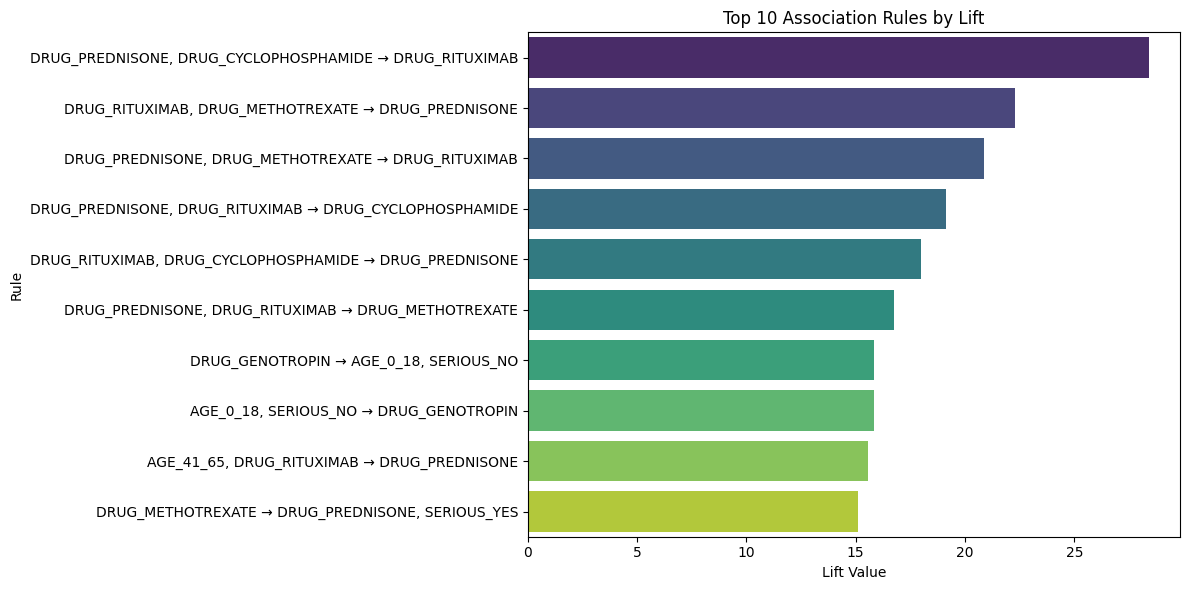

In [137]:
# === TOP 10 ASSOCIATION RULES BY LIFT ===

# Sort by lift
top10_lift = rules.sort_values(by="lift", ascending=False).head(10).copy()

# readable rule strings
top10_lift["antecedents_str"] = top10_lift["antecedents"].apply(lambda x: ", ".join(list(x)))
top10_lift["consequents_str"] = top10_lift["consequents"].apply(lambda x: ", ".join(list(x)))
top10_lift["rule"] = top10_lift["antecedents_str"] + " → " + top10_lift["consequents_str"]

# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    data=top10_lift,
    x="lift",
    y="rule",
    palette="viridis"
)
plt.title("Top 10 Association Rules by Lift")
plt.xlabel("Lift Value")
plt.ylabel("Rule")
plt.tight_layout()
plt.show()


# Visualize Top-20 Drugs & REACTIONS

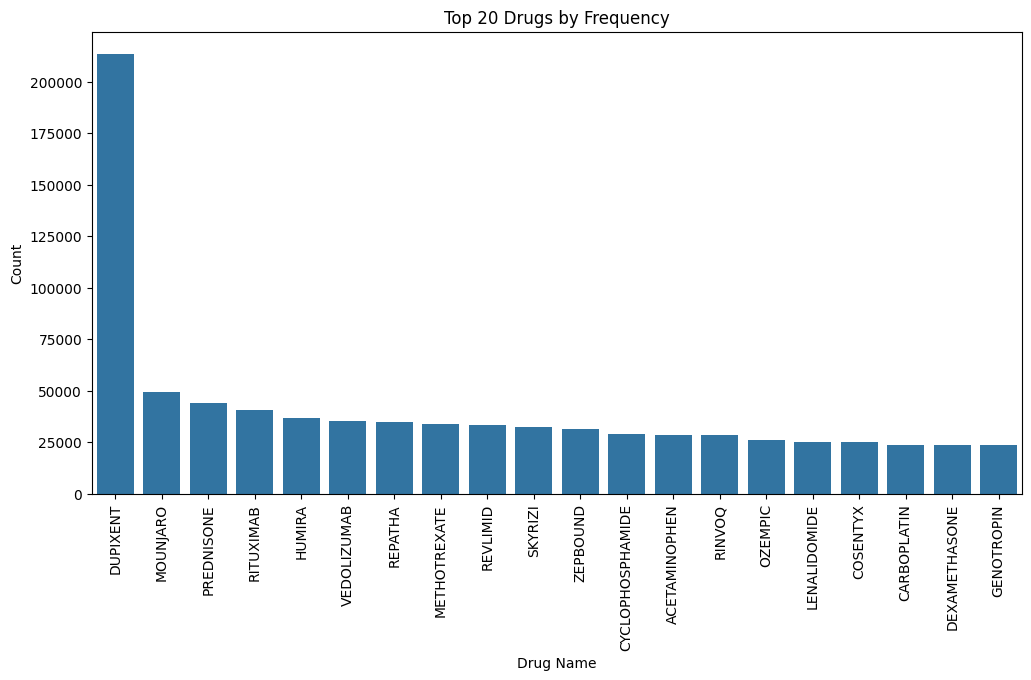

In [124]:
plt.figure(figsize=(12,6))
sns.barplot(x=top_drugs, y=drug_counts[top_drugs].values)
plt.xticks(rotation=90)
plt.title("Top 20 Drugs by Frequency")
plt.xlabel("Drug Name")
plt.ylabel("Count")
plt.show()


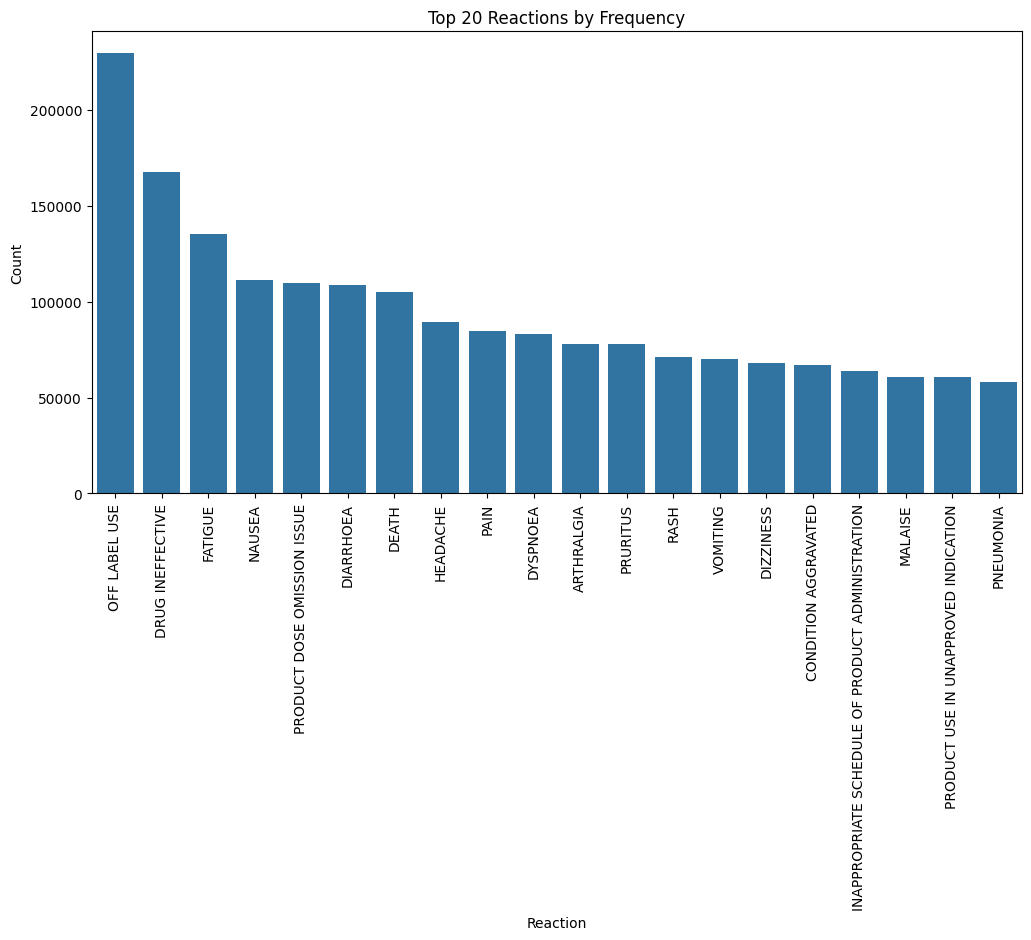

In [125]:
plt.figure(figsize=(12,6))
sns.barplot(x=top_reactions, y=reaction_counts[top_reactions].values)
plt.xticks(rotation=90)
plt.title("Top 20 Reactions by Frequency")
plt.xlabel("Reaction")
plt.ylabel("Count")
plt.show()


## VISUALIZATION: RULE METRICS

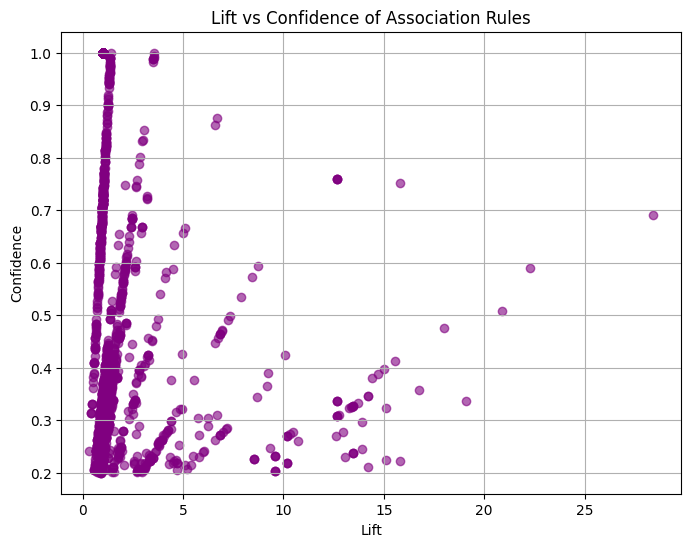

In [126]:
plt.figure(figsize=(8,6))
plt.scatter(rules['lift'], rules['confidence'], alpha=0.6, c='purple')
plt.xlabel("Lift")
plt.ylabel("Confidence")
plt.title("Lift vs Confidence of Association Rules")
plt.grid(True)
plt.show()


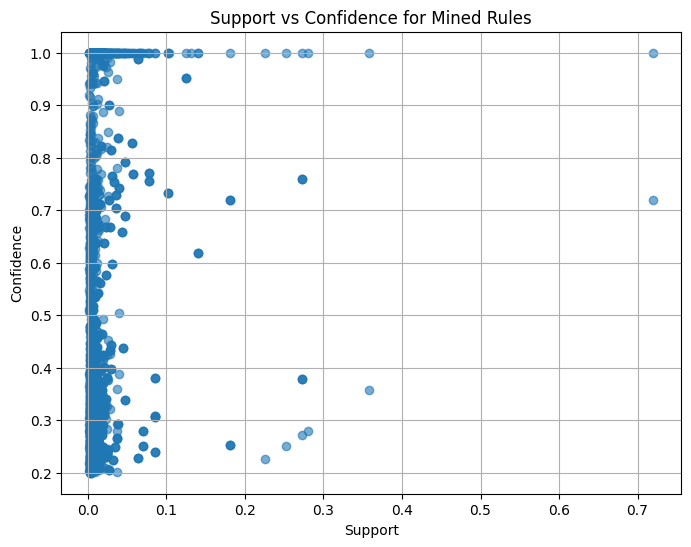

In [127]:
plt.figure(figsize=(8,6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.6)
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Support vs Confidence for Mined Rules")
plt.grid(True)
plt.show()


## VALIDATION: CREATE SECOND SAMPLE

In [128]:
df_reduced["age_bucket"] = pd.cut(
    df_reduced["age_years"],
    bins=[0,18,40,65,200],
    labels=["AGE_0_18","AGE_19_40","AGE_41_65","AGE_65PLUS"],
    include_lowest=True
).astype(str)

df_reduced["sex_bucket"] = df_reduced["sex_clean"].map({
    "M":"SEX_M",
    "F":"SEX_F"
}).fillna("SEX_OTHER")

df_reduced["serious_flag"] = df_reduced["is_serious_outcome"].apply(
    lambda x: "SERIOUS_YES" if x==1 else "SERIOUS_NO"
)

print("Added demographic buckets to df_reduced!")


Added demographic buckets to df_reduced!


In [129]:
print("\n=== VALIDATION: Creating Second Sample ===")
df_sample2 = df_reduced.sample(100000, random_state=99).copy()

df_sample2["items"] = df_sample2.apply(build_items, axis=1)

print("Second sample shape:", df_sample2.shape)



=== VALIDATION: Creating Second Sample ===
Second sample shape: (100000, 27)


## VALIDATION: RUN FP-GROWTH ON SAMPLE 2

In [130]:
te2 = TransactionEncoder()
df_binary2 = pd.DataFrame(
    te2.fit(df_sample2["items"]).transform(df_sample2["items"]),
    columns=te2.columns_
)

frequent_itemsets_2 = fpgrowth(
    df_binary2,
    min_support=MIN_SUPPORT,
    use_colnames=True,
    max_len=MAX_LEN
)

rules2 = association_rules(
    frequent_itemsets_2,
    metric="confidence",
    min_threshold=0.2
)

print("Rules in sample 2:", len(rules2))


Rules in sample 2: 1913


/usr/local/lib/python3.12/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


## VALIDATION: CHECK SAMPLE OVERLAP

In [131]:
ids_sample1 = set(df_sample["primaryid"])
ids_sample2 = set(df_sample2["primaryid"])

overlap_count = len(ids_sample1.intersection(ids_sample2))
unique_sample1 = len(ids_sample1 - ids_sample2)
unique_sample2 = len(ids_sample2 - ids_sample1)

print("Sample 1 size:", len(ids_sample1))
print("Sample 2 size:", len(ids_sample2))
print("Overlapping IDs:", overlap_count)
print("Unique to Sample 1:", unique_sample1)
print("Unique to Sample 2:", unique_sample2)


Sample 1 size: 100000
Sample 2 size: 100000
Overlapping IDs: 6250
Unique to Sample 1: 93750
Unique to Sample 2: 93750


## PREPARE MATRIX X FOR CLUSTERING

In [132]:
X = df_binary.values   # shape (100000, 48)
print("Clustering feature matrix shape:", X.shape)


Clustering feature matrix shape: (100000, 48)


## PCA (10 COMPONENTS)

In [133]:
pca_10 = PCA(n_components=10, random_state=42)
X_pca_10 = pca_10.fit_transform(X)

print("PCA-reduced shape:", X_pca_10.shape)
print("Explained variance (first 10 PCs):",
      np.round(pca_10.explained_variance_ratio_.sum(), 3))


PCA-reduced shape: (100000, 10)
Explained variance (first 10 PCs): 0.622


## SILHOUETTE ANALYSIS TO FIND BEST K

In [134]:
subset_size = 20000
X_sub = X_pca_10[:subset_size]

sil_scores = {}

for k in range(3, 9):
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_tmp = kmeans_tmp.fit_predict(X_sub)
    score = silhouette_score(X_sub, labels_tmp)
    sil_scores[k] = score
    print(f"K = {k}, Silhouette Score = {score:.4f}")

print("\nSilhouette scores:", sil_scores)


K = 3, Silhouette Score = 0.2776
K = 4, Silhouette Score = 0.3360
K = 5, Silhouette Score = 0.3725
K = 6, Silhouette Score = 0.4051
K = 7, Silhouette Score = 0.4453
K = 8, Silhouette Score = 0.4698

Silhouette scores: {3: np.float64(0.2775743169464873), 4: np.float64(0.3359870362563384), 5: np.float64(0.3724636964033503), 6: np.float64(0.4050952797337835), 7: np.float64(0.4453220914991614), 8: np.float64(0.46983595201019634)}


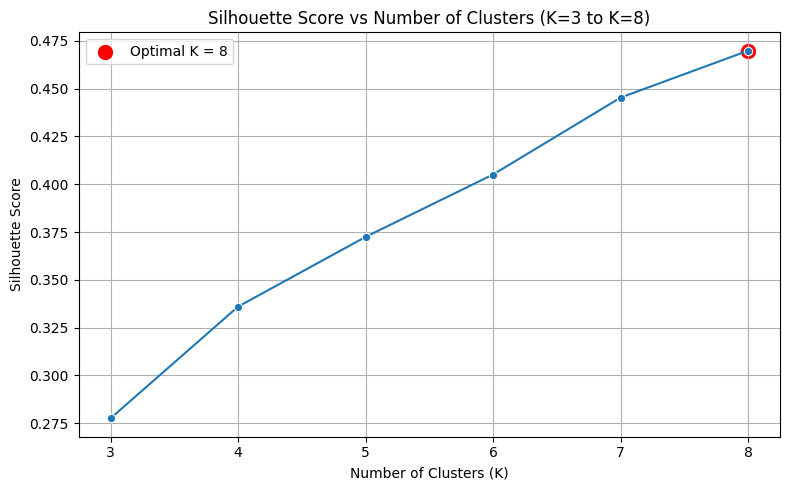

In [139]:
# === SILHOUETTE ANALYSIS PLOT (K = 3 to K = 8) ===

# Convert silhouette score dictionary to lists for plotting
k_values = list(sil_scores.keys())
scores = list(sil_scores.values())

plt.figure(figsize=(8,5))
sns.lineplot(x=k_values, y=scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters (K=3 to K=8)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)

# Highlight optimal K = 8
best_k = max(sil_scores, key=sil_scores.get)
best_score = sil_scores[best_k]

plt.scatter(best_k, best_score, color='red', s=100, label=f"Optimal K = {best_k}")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


## FINAL CLUSTERING (K = 8)

In [135]:
K = 8  # Best silhouette score

kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca_10)

df_sample["cluster"] = cluster_labels

print("Cluster counts:")
print(df_sample["cluster"].value_counts().sort_index())


Cluster counts:
cluster
0     7809
1     8609
2    12339
3    18150
4    27258
5     7044
6    14008
7     4783
Name: count, dtype: int64


/tmp/ipython-input-3332353911.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


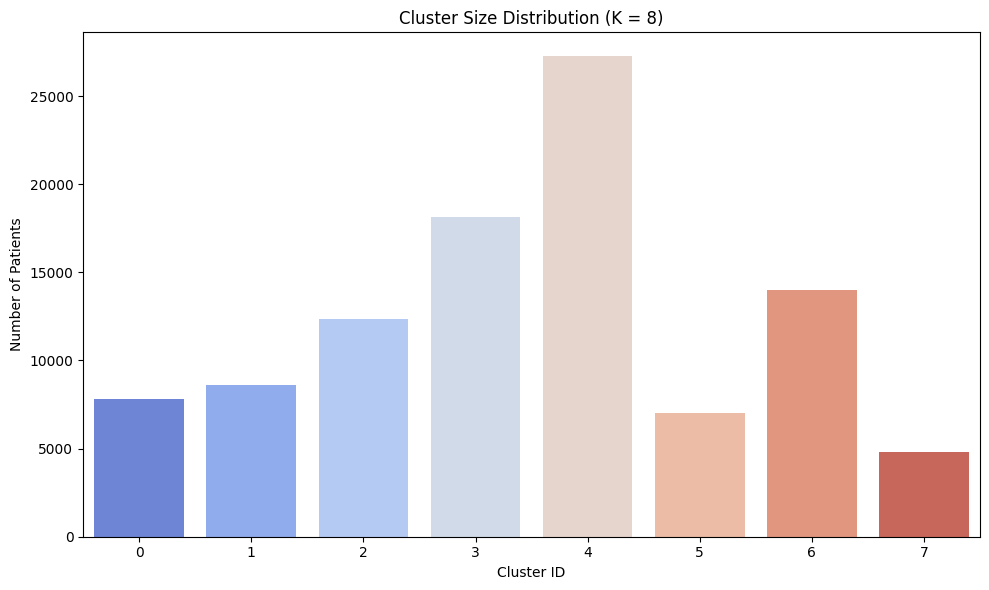

In [138]:
# === CLUSTER SIZE DISTRIBUTION (K = 8) ===

cluster_counts = df_sample["cluster"].value_counts().sort_index()

plt.figure(figsize=(10,6))
sns.barplot(
    x=cluster_counts.index,
    y=cluster_counts.values,
    palette="coolwarm"
)
plt.title("Cluster Size Distribution (K = 8)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show()


## CLUSTER INTERPRETATION

In [136]:
# FIX INDEX ALIGNMENT
df_sample = df_sample.reset_index(drop=True)
df_binary = df_binary.reset_index(drop=True)

cluster_summary = {}

for c in range(8):   # K = 8
    idx = (df_sample["cluster"] == c)

    size = idx.sum()

    # Extract top items properly
    top_items = df_binary[idx].mean().sort_values(ascending=False).head(12)

    age_dist = df_sample.loc[idx, "age_bucket"].value_counts(normalize=True)
    sex_dist = df_sample.loc[idx, "sex_bucket"].value_counts(normalize=True)
    serious_dist = df_sample.loc[idx, "serious_flag"].value_counts(normalize=True)

    cluster_summary[c] = {
        "size": size,
        "top_items": top_items,
        "age_dist": age_dist,
        "sex_dist": sex_dist,
        "serious_dist": serious_dist
    }

    print("\n====================================")
    print(f"CLUSTER {c}  | Size: {size}")
    print("====================================")

    print("\nTop Items (Drugs / Reactions / Demographics):")
    print(top_items)

    print("\nAge Distribution:")
    print(age_dist)

    print("\nSex Distribution:")
    print(sex_dist)

    print("\nSerious Outcome Distribution:")
    print(serious_dist)



CLUSTER 0  | Size: 7809

Top Items (Drugs / Reactions / Demographics):
AGE_19_40                            1.000000
SEX_OTHER                            1.000000
SERIOUS_NO                           1.000000
DRUG_DUPIXENT                        0.303240
REACT_OFF_LABEL_USE                  0.145985
REACT_DRUG_INEFFECTIVE               0.101037
REACT_PRODUCT_DOSE_OMISSION_ISSUE    0.083621
REACT_PRURITUS                       0.082469
REACT_NAUSEA                         0.073249
REACT_FATIGUE                        0.068127
REACT_HEADACHE                       0.063260
REACT_PAIN                           0.049174
dtype: float64

Age Distribution:
age_bucket
AGE_19_40    1.0
Name: proportion, dtype: float64

Sex Distribution:
sex_bucket
SEX_OTHER    1.0
Name: proportion, dtype: float64

Serious Outcome Distribution:
serious_flag
SERIOUS_NO    1.0
Name: proportion, dtype: float64

CLUSTER 1  | Size: 8609

Top Items (Drugs / Reactions / Demographics):
AGE_65PLUS                1.000000